In [5]:
from utils.plotter import get_roc_curves_from_df
from utils.wandb_calls import fetch_files_from_runs
from utils import bad_runs
import os
import pandas as pd
import pickle
import shutil

### Download

In [23]:
for folder in os.listdir("./results/"):
    if "acdc" in folder or "sp" in folder:
        shutil.rmtree(f"./results/{folder}")


In [24]:
project = "circuit_discovery"
# group = "acdc"
files_to_fetch = ["result.pkl"]
fetch_files_from_runs(project, "", files_to_fetch)

100%|██████████| 735/735 [02:41<00:00,  4.56it/s]


### ROC

In [2]:
from utils.get_circuit_discovery_scores import walk_dirs_and_get_scores
import pandas as pd
# walk_dirs_and_get_scores("acdc")
acdc_510_scores = walk_dirs_and_get_scores(weight=510, algorithm="acdc")
node_sp_510_scores = walk_dirs_and_get_scores(weight=510, algorithm="node_sp")
edge_sp_510_scores = walk_dirs_and_get_scores(weight=510, algorithm="edge_sp")

results/acdc_3/weight_510
results/acdc_4/weight_510
Skipping 4
results/acdc_11/weight_510
results/acdc_16/weight_510
Skipping 16
results/acdc_21/weight_510
results/acdc_38/weight_510
Skipping 38
results/acdc_8/weight_510
results/acdc_24/weight_510
results/acdc_13/weight_510
results/node_sp_8/weight_510
results/node_sp_11/weight_510
Skipping 16
results/node_sp_21/weight_510
Skipping 38
results/node_sp_3/weight_510
results/node_sp_24/weight_510
results/node_sp_13/weight_510
results/edge_sp_24/weight_510
results/edge_sp_13/weight_510
results/edge_sp_3/weight_510
Skipping 38
Skipping 16
results/edge_sp_11/weight_510
results/edge_sp_21/weight_510
results/edge_sp_8/weight_510


/Users/cybershiptrooper/src/interpretability/MATS/circuits-benchmark/notebooks/utils/get_circuit_discovery_scores.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([
/Users/cybershiptrooper/src/interpretability/MATS/circuits-benchmark/notebooks/utils/get_circuit_discovery_scores.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([
/Users/cybershiptrooper/src/interpretability/MATS/circuits-benchmark/notebooks/utils/get_circuit_discovery_scores.py:24: FutureW

In [2]:
# edge_sp_510_scores

In [3]:
node_sp_510_scores["run"].unique(), acdc_510_scores["run"].unique()

(array(['8', '11', '21', '3', '24', '13'], dtype=object),
 array(['3', '11', '21', '8', '24', '13'], dtype=object))

In [4]:
from utils.plotter import pessimistic_auc as auc

def make_fpr_tpr_monotonic(fpr_list, tpr_list):
    # return sorted fpr and corresponding tpr  (i.e., if fpr[i] -> fpr[j] then tpr[i] -> tpr[j])
    fpr_tpr = list(zip(fpr_list, tpr_list))
    fpr_tpr = sorted(fpr_tpr, key=lambda x: x[0])
    fpr_list, tpr_list = zip(*fpr_tpr)
    return list(fpr_list), list(tpr_list)

def get_ROCs(scores: pd.DataFrame, algorithm: str):
    if algorithm == "acdc":
        sort_key = "threshold"
        ascending = False
    elif "sp" in algorithm:
        sort_key = "lambda"
        ascending = True
    rocs = {} # run : {node: node_roc, edge: edge_roc}
    scores_by_run = scores.groupby("run")
    for run, run_scores in scores_by_run:
        run_scores = run_scores.sort_values(by=sort_key, ascending=ascending)
        # get 'node_tpr', 'node_fpr', 'edge_tpr', 'edge_fpr' from run_scores
        node_fpr = list(run_scores["node_fpr"].values.copy())
        node_tpr = list(run_scores["node_tpr"].values.copy())
        edge_fpr = list(run_scores["edge_fpr"].values.copy())
        edge_tpr = list(run_scores["edge_tpr"].values.copy())
        # print(node_fpr, node_tpr)
        # make fpr and tpr lists monotonic
        # node_fpr, node_tpr = make_fpr_tpr_monotonic(node_fpr, node_tpr)
        # edge_fpr, edge_tpr = make_fpr_tpr_monotonic(edge_fpr, edge_tpr)

        # calculate roc_auc for node and edge
        try:
            node_roc = auc(node_fpr, node_tpr)
            edge_roc = auc(edge_fpr, edge_tpr)
        except:
            print(f"error in run {run}")
            continue
        rocs[run] = {"node": node_roc, "edge": edge_roc}
    return rocs

In [5]:
from utils.get_circuit_discovery_scores import append_row
# make 2 combined dataframes: one for node_roc and one for edge_roc

def get_combined_roc_dfs(acdc_rocs, node_sp_rocs):
    node_roc_df = pd.DataFrame()
    edge_roc_df = pd.DataFrame()

    for k, v in acdc_rocs.items():
        run = k
        acdc_node_roc = v["node"]
        acdc_edge_roc = v["edge"]
        node_sp_node_roc = node_sp_rocs[k]["node"]
        node_sp_edge_roc = node_sp_rocs[k]["edge"]
        node_entry = {"run": run, "acdc": acdc_node_roc, "node_sp": node_sp_node_roc}
        edge_entry = {"run": run, "acdc": acdc_edge_roc, "node_sp": node_sp_edge_roc}
        node_roc_df = append_row(node_roc_df, pd.Series(node_entry))
        edge_roc_df = append_row(edge_roc_df, pd.Series(edge_entry))

    return node_roc_df, edge_roc_df


def get_combined_roc_df_from_list(list_of_rocs, list_of_names):
    node_roc_df = pd.DataFrame()
    edge_roc_df = pd.DataFrame()

    for k, v in list_of_rocs[0].items():
        run = k
        node_roc = v["node"]
        edge_roc = v["edge"]
        node_entry = {"run": run, list_of_names[0]: node_roc}
        edge_entry = {"run": run, list_of_names[0]: edge_roc}
        for i, rocs in enumerate(list_of_rocs[1:]):
            node_roc = rocs[k]["node"]
            edge_roc = rocs[k]["edge"]
            node_entry[list_of_names[i+1]] = node_roc
            edge_entry[list_of_names[i+1]] = edge_roc
        node_roc_df = append_row(node_roc_df, pd.Series(node_entry))
        edge_roc_df = append_row(edge_roc_df, pd.Series(edge_entry))
    

    return node_roc_df, edge_roc_df

In [6]:
acdc_rocs = get_ROCs(acdc_510_scores, "acdc")
node_sp_rocs = get_ROCs(node_sp_510_scores, "node_sp")
edge_sp_rocs = get_ROCs(edge_sp_510_scores, "edge_sp")
node_roc_df_510, edge_roc_df_510 = get_combined_roc_dfs(acdc_rocs, node_sp_rocs)

In [8]:
node_roc_df, edge_roc_df = get_combined_roc_df_from_list([acdc_rocs, node_sp_rocs, edge_sp_rocs], ["acdc", "node_sp", "edge_sp"])

In [9]:
node_roc_df

,run,acdc,node_sp,edge_sp
0,11,1.000000,0.125000,0.000000
1,13,1.000000,0.500000,0.166667
2,21,0.888889,0.333333,0.222222
3,24,0.888889,0.333333,0.222222
4,3,0.857143,0.857143,0.964286
5,8,0.750000,0.000000,0.000000


In [ ]:
acdc_tracr_scores = walk_dirs_and_get_scores(weight="tracr", algorithm="acdc")
node_sp_tracr_scores = walk_dirs_and_get_scores(weight="tracr", algorithm="node_sp")
edge_sp_tracr_scores = walk_dirs_and_get_scores(weight="tracr", algorithm="edge_sp")

In [16]:
df_8 = node_sp_510_scores.groupby('run').get_group('13').sort_values(by='node_fpr', ascending=True)
ntprs_8 = df_8['node_tpr'].values
nfprs_8 = df_8['node_fpr'].values

auc_8 = auc(nfprs_8, ntprs_8)
print("fprs:", nfprs_8)
print("tprs:", ntprs_8)
print("auc:", auc_8)

fprs: [0.5        0.66666667 0.83333333 1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.        ]
tprs: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
auc: 0.5


In [11]:
acdc_tracr_rocs = get_ROCs(acdc_tracr_scores, "acdc")
node_sp_tracr_rocs = get_ROCs(node_sp_tracr_scores, "node_sp")
edge_sp_tracr_rocs = get_ROCs(edge_sp_tracr_scores, "edge_sp")

In [12]:
node_roc_df_tracr, edge_roc_df_tracr = get_combined_roc_dfs(acdc_tracr_rocs, node_sp_tracr_rocs)

In [13]:
node_roc_df_tracr

,run,acdc,node_sp
0,11,1.0,0.5
1,13,1.0,1.0
2,21,1.0,0.0
3,24,1.0,0.0
4,3,1.0,0.5


Text(0.5, 1.0, 'Edge ROC AUC')

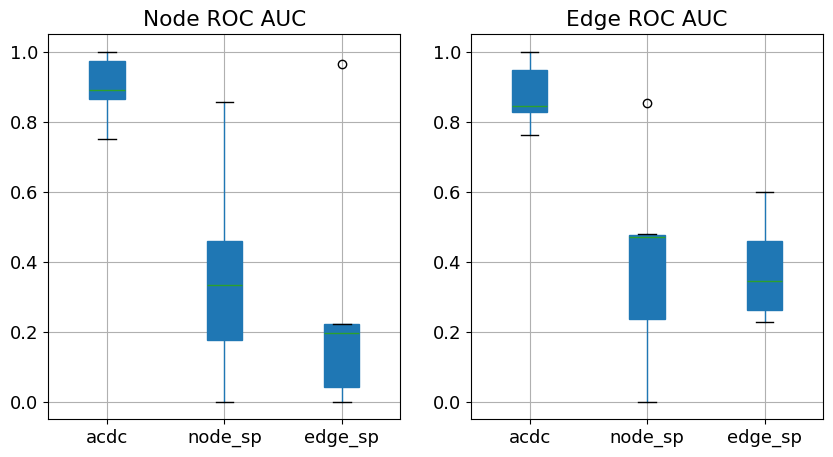

In [14]:
# make box plots for node and edge roc_auc
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

node_roc_df.boxplot(ax=ax[0], 
                    column=["acdc", "node_sp", "edge_sp"],
                    patch_artist=True,
                    showfliers=True,
                    # whis=[5, 95],
                    )
edge_roc_df.boxplot(ax=ax[1],
                    column=["acdc", "node_sp", "edge_sp"],
                    patch_artist=True,
                    showfliers=True,
                    # whis=[5, 95],
                    )
# set title
ax[0].set_title("Node ROC AUC")
ax[1].set_title("Edge ROC AUC")

Text(0.5, 1.0, 'Edge ROC AUC')

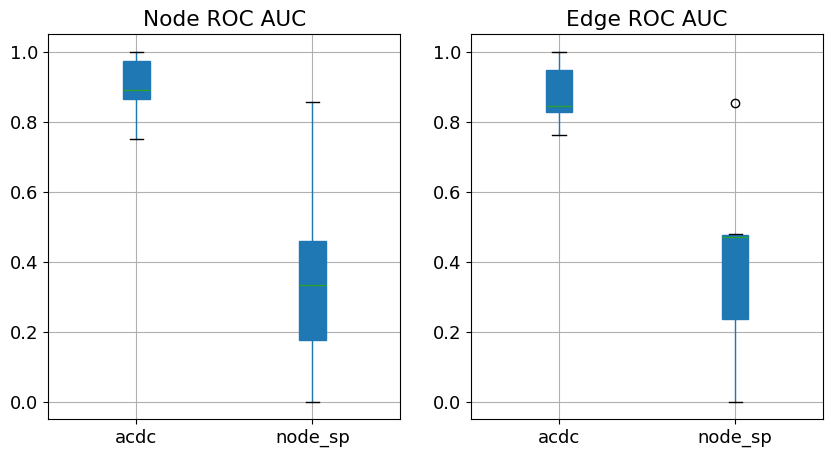

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

node_roc_df_510.boxplot(ax=ax[0],
                    column=["acdc", "node_sp"], 
                    patch_artist=True,
                    showfliers=True,
                    # whis=[5, 95],
                    )

edge_roc_df_510.boxplot(ax=ax[1],
                    column=["acdc", "node_sp"], 
                    patch_artist=True,
                    showfliers=True,
                    # whis=[5, 95],
                    )
# set title
ax[0].set_title("Node ROC AUC")
ax[1].set_title("Edge ROC AUC")


Text(0.5, 1.0, 'Node ROC AUC for TRACR')

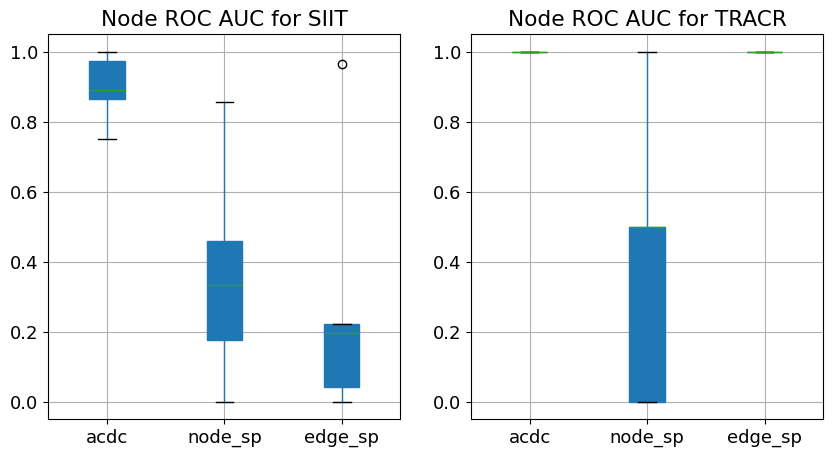

In [16]:
# make box plots for node and edge roc_auc
import matplotlib.pyplot as plt

combined_df_510_nodes, combined_df_510_edges = get_combined_roc_df_from_list([acdc_rocs, node_sp_rocs, edge_sp_rocs], ["acdc", "node_sp", "edge_sp"])
combined_df_tracr_nodes, combined_df_tracr_edges = get_combined_roc_df_from_list([acdc_tracr_rocs, node_sp_tracr_rocs, edge_sp_tracr_rocs], ["acdc", "node_sp", "edge_sp"])

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
combined_df_510_nodes.boxplot(ax=ax[0],
                    column=["acdc", "node_sp", "edge_sp"],
                    patch_artist=True,
                    showfliers=True,
                    # whis=[5, 95],
                    )
combined_df_tracr_nodes.boxplot(ax=ax[1],
                    column=["acdc", "node_sp", "edge_sp"],
                    patch_artist=True,
                    showfliers=True,
                    # whis=[5, 95],
                    )


ax[0].set_title("Node ROC AUC for SIIT")
ax[1].set_title("Node ROC AUC for TRACR")

### Realism

In [19]:
from utils.get_circuit_discovery_scores import get_realism_scores
acdc_510_realism = get_realism_scores(weight=510, algorithm="acdc")
node_sp_510_realism = get_realism_scores(weight=510, algorithm="node_sp")
edge_sp_510_realism = get_realism_scores(weight=510, algorithm="edge_sp")

/Users/cybershiptrooper/src/interpretability/MATS/circuits-benchmark/notebooks/utils/get_circuit_discovery_scores.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([
/Users/cybershiptrooper/src/interpretability/MATS/circuits-benchmark/notebooks/utils/get_circuit_discovery_scores.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([
/Users/cybershiptrooper/src/interpretability/MATS/circuits-benchmark/notebooks/utils/get_circuit_discovery_scores.py:24: FutureW

In [20]:
from utils.realism_helper import get_best_score, make_combined_realism_df

In [21]:
acdc_510_best_realism = get_best_score(acdc_510_realism)
node_sp_510_best_realism = get_best_score(node_sp_510_realism)
edge_sp_510_best_realism = get_best_score(edge_sp_510_realism)

In [22]:
combined_realism_df_510 = make_combined_realism_df(acdc_510_best_realism, node_sp_510_best_realism)
combined_realism_df_510

,run,acdc,node_sp
0,11,0.474224,0.436851
1,13,0.492938,0.492940
2,21,0.590546,0.400278
3,24,0.590546,0.400278
4,3,0.307617,0.307617
5,8,0.269310,0.249977


In [23]:
import pandas as pd
from utils.get_circuit_discovery_scores import append_row
def make_combined_realism_df_from_list(list_of_realism_dfs, list_of_labels):
    # check if labels are unique
    assert len(list_of_labels) == len(set(list_of_labels)), "Labels are not unique"
    combined_realism_df = pd.DataFrame()
    for k, v in list_of_realism_dfs[0].items():
        run = k
        realism_entry = v
        realism_label = list_of_labels[0]
        entry = {"run": run, realism_label: realism_entry}
        for i in range(1, len(list_of_realism_dfs)):
            realism_entry = list_of_realism_dfs[i][k]
            realism_label = list_of_labels[i]
            entry[realism_label] = realism_entry
        
        combined_realism_df = append_row(combined_realism_df, pd.Series(entry))
    return combined_realism_df

In [24]:
acdc_110_realism = get_realism_scores(weight="110", algorithm="acdc")

In [25]:
acdc_100_realism = get_realism_scores(weight="100", algorithm="acdc")
acdc_tracr_realism = get_realism_scores(weight="tracr", algorithm="acdc")
acdc_100_best_realism = get_best_score(acdc_100_realism)
acdc_tracr_best_realism = get_best_score(acdc_tracr_realism)

node_sp_100_realism = get_realism_scores(weight="100", algorithm="node_sp")
node_sp_tracr_realism = get_realism_scores(weight="tracr", algorithm="node_sp")
node_sp_100_best_realism = get_best_score(node_sp_100_realism)
node_sp_tracr_best_realism = get_best_score(node_sp_tracr_realism)

edge_sp_100_realism = get_realism_scores(weight="100", algorithm="edge_sp")
edge_sp_tracr_realism = get_realism_scores(weight="tracr", algorithm="edge_sp")
edge_sp_100_best_realism = get_best_score(edge_sp_100_realism)
edge_sp_tracr_best_realism = get_best_score(edge_sp_tracr_realism)


/Users/cybershiptrooper/src/interpretability/MATS/circuits-benchmark/notebooks/utils/get_circuit_discovery_scores.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([
/Users/cybershiptrooper/src/interpretability/MATS/circuits-benchmark/notebooks/utils/get_circuit_discovery_scores.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([
/Users/cybershiptrooper/src/interpretability/MATS/circuits-benchmark/notebooks/utils/get_circuit_discovery_scores.py:24: FutureW

In [26]:
combined_realism_df = make_combined_realism_df_from_list(
    [acdc_510_best_realism, acdc_100_best_realism, acdc_tracr_best_realism],
    ["SIIT", "natural", "tracr"]
)

combined_realism_df

,run,SIIT,natural,tracr
0,11,0.474224,0.449420,0.436851
1,13,0.492938,0.674353,0.493942
2,21,0.590546,0.587903,1.000000
3,24,0.590546,0.587903,1.000000
4,3,0.307617,0.357617,0.285938
5,8,0.269310,0.212377,0.214126


Text(0.5, 1.0, 'Realism scores')

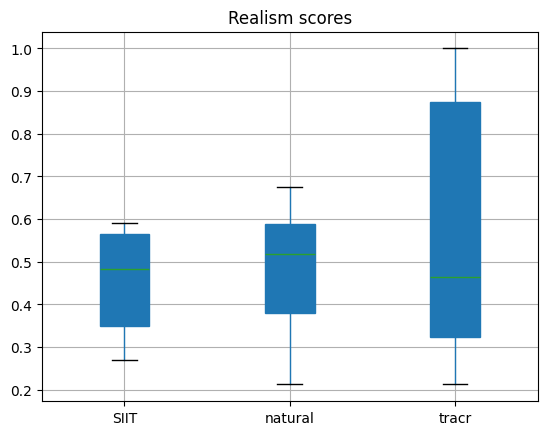

In [27]:
# plot realism score for 510, 100 and tracr
import matplotlib.pyplot as plt

combined_realism_df.boxplot(ax=plt.gca(),
                    column=["SIIT", "natural", "tracr"],
                    patch_artist=True,
                    showfliers=True,
                    # whis=[5, 95],
                    )

plt.title("Realism scores")


In [28]:
node_sp_100_mean_realism = get_best_score(node_sp_100_realism, mean=True)
acdc_100_mean_realism = get_best_score(acdc_100_realism, mean=True)
node_sp_510_mean_realism = get_best_score(node_sp_510_realism, mean=True)
acdc_510_mean_realism = get_best_score(acdc_510_realism, mean=True)

combined_realism_df_100_mean = make_combined_realism_df(acdc_100_mean_realism, node_sp_100_mean_realism)
combined_realism_df_510_mean = make_combined_realism_df(acdc_510_mean_realism, node_sp_510_mean_realism)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

combined_realism_df_510_mean.boxplot(ax=ax[0],
                    column=["acdc", "node_sp"], 
                    patch_artist=True,
                    showfliers=True,
                    # whis=[5, 95],
                    )

combined_realism_df_100_mean.boxplot(ax=ax[1],
                    column=["acdc", "node_sp"], 
                    patch_artist=True,
                    showfliers=True,
                    # whis=[5, 95],
                    )

ax[0].set_title("Mean Realism Scores for Weight SIIT")
ax[1].set_title("Mean Realism Scores for Weight Natural Model")


KeyError: '11'

Text(0.5, 1.0, 'Realism Scores for Weight tracr')

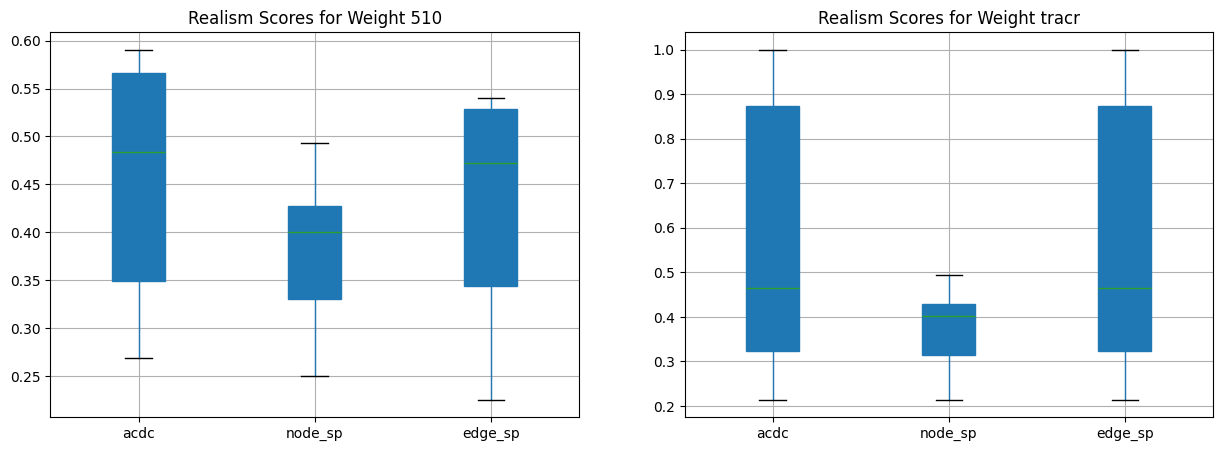

In [ ]:
combined_realism_510 = make_combined_realism_df_from_list([
    acdc_510_best_realism, node_sp_510_best_realism, edge_sp_510_best_realism
], ["acdc", "node_sp", "edge_sp"])

# combined_realism_100 = make_combined_realism_df_from_list([
#     acdc_100_best_realism, node_sp_100_best_realism, edge_sp_100_best_realism
# ], ["acdc", "node_sp", "edge_sp"])

combined_realism_tracr = make_combined_realism_df_from_list([
    acdc_tracr_best_realism, node_sp_tracr_best_realism, edge_sp_tracr_best_realism
], ["acdc", "node_sp", "edge_sp"])

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

combined_realism_510.boxplot(ax=ax[0],
                    column=["acdc", "node_sp", "edge_sp"],
                    patch_artist=True,
                    showfliers=True,
                    # whis=[5, 95],
                    )
# combined_realism_100.boxplot(ax=ax[1],
#                     column=["acdc", "node_sp", "edge_sp"],
#                     patch_artist=True,
#                     showfliers=True,
#                     # whis=[5, 95],
#                     )
combined_realism_tracr.boxplot(ax=ax[1],
                    column=["acdc", "node_sp", "edge_sp"],
                    patch_artist=True,
                    showfliers=True,
                    # whis=[5, 95],
                    )

ax[0].set_title("Realism Scores for Weight 510")
ax[1].set_title("Realism Scores for Weight tracr")
# ax[2].set_title("Realism Scores for Weight tracr")

In [ ]:
combined_realism_df_510_mean, combined_realism_df_100_mean

(  run      acdc   node_sp
 0  11  0.474224  0.436851
 1  13  0.492938  0.492940
 2  21  0.590546  0.400278
 3  24  0.590546  0.400278
 4   3  0.307617  0.307617
 5   8  0.269310  0.249977,
   run      acdc   node_sp
 0  11  0.474224  0.436851
 1  13  0.492938  0.492940
 2  21  0.590546  0.400278
 3  24  0.590546  0.400278
 4   3  0.307617  0.307617
 5   8  0.269310  0.249977)